In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun 16 13:44:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install keras_hist_graph

In [3]:
import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten, Input, ZeroPadding2D,InputLayer
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop, SGD
from keras.callbacks import History, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.constraints import unit_norm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras_hist_graph import plot_history
%matplotlib inline

In [4]:
pip install livelossplot

In [5]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import decode_predictions, preprocess_input, VGG16
from keras.applications.resnet_v2 import ResNet50V2
from livelossplot.inputs.keras import PlotLossesCallback

In [6]:
#set the training path
training_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/training_data'
#set the validation path
validation_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/validation_data'
#set the test path
test_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data'

## Augmented data: Rotation 90 degrees

## **Using Pre-trained Layers for Fine-Tuning**

## Setting the data

In [ ]:
breeds=['chow','collie','cairn','dhole','dingo']

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20)

Found 553 images belonging to 5 classes.


In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 172 images belonging to 5 classes.


In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 127 images belonging to 5 classes.


In [ ]:
classes=len(breeds)

In [ ]:
def create_model(n_classes,tuning_layers):

  #Import the pre-trained VGG model without the fully connected layers on top
  conv_res50=ResNet50V2(weights='imagenet', 
                  include_top = False,
                  input_shape = (224,224, 3))

  #setting the fine-tuning loop
  if tuning_layers==0:
    conv_res50.trainable=False
  else:
    for layer in conv_res50.layers[:-tuning_layers]:
      layer.trainable=False

  #bootstrapping a new top_model into the pre-trained model

  model=Sequential()
  model.add(conv_res50)
  model.add(Flatten())
  model.add(Dense(512, activation='relu',input_shape=(None,100352)))
  model.add(Dropout(0.3))
  model.add(Dense(n_classes,activation='softmax'))

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
  
  return model

### Without using fine-tuning

In [ ]:
res_0=create_model(n_classes=classes, tuning_layers=0)

In [ ]:
res_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 74,948,101
Trainable params: 51,383,301
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
plot_tun0=PlotLossesCallback()

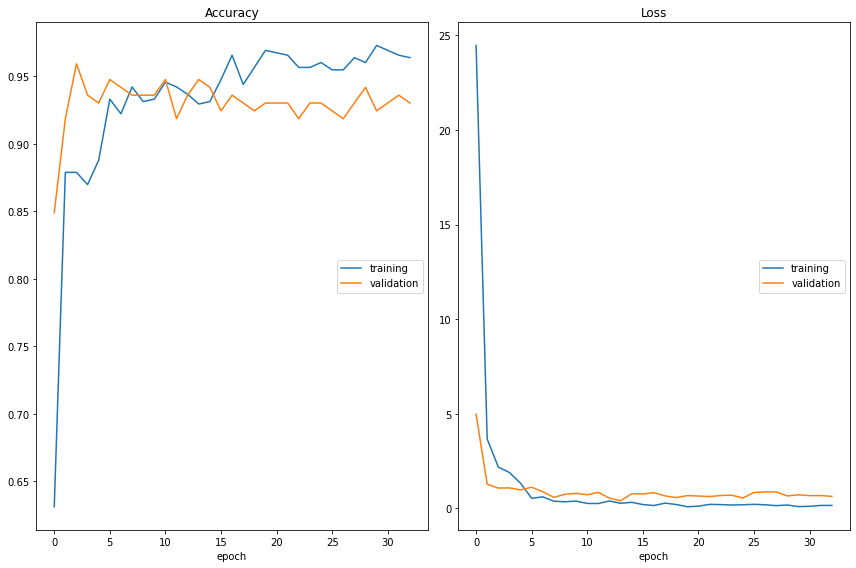

Accuracy
	training         	 (min:    0.631, max:    0.973, cur:    0.964)
	validation       	 (min:    0.849, max:    0.959, cur:    0.930)
Loss
	training         	 (min:    0.093, max:   24.473, cur:    0.162)
	validation       	 (min:    0.408, max:    4.982, cur:    0.645)
Epoch 00033: early stopping


In [ ]:
history_res50=res_0.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/5_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0
              ])

In [ ]:
res_0=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/5_breeds/no_fine_tuning')

In [ ]:
res_0.evaluate(aug_test)

7/7 [==============================] - 34s 5s/step - loss: 0.9594 - acc: 0.9528


[0.9593746662139893, 0.9527559280395508]

### keeping last convolutional layer trainable

In [ ]:
res_1=create_model(n_classes=classes, tuning_layers=4)

In [ ]:
res_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 74,948,101
Trainable params: 52,438,021
Non-trainable params: 22,510,080
_________________________________________________________________


In [ ]:
plot_tun1=PlotLossesCallback()

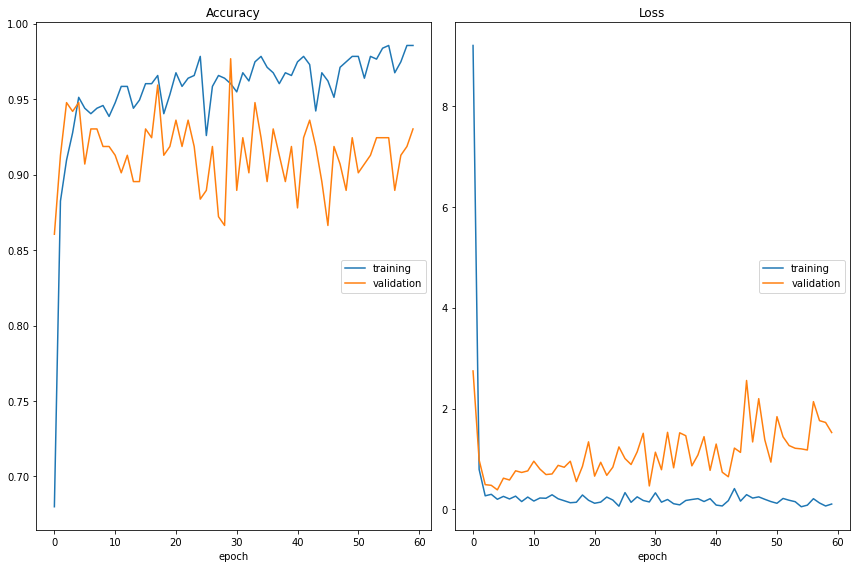

Accuracy
	training         	 (min:    0.680, max:    0.986, cur:    0.986)
	validation       	 (min:    0.860, max:    0.977, cur:    0.930)
Loss
	training         	 (min:    0.055, max:    9.198, cur:    0.108)
	validation       	 (min:    0.389, max:    2.746, cur:    1.525)
Epoch 00060: early stopping


In [ ]:
history_res50_1=res_1.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/5_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
res_1=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/5_breeds/fine_tuning')

In [ ]:
res_1.evaluate(aug_test)

7/7 [==============================] - 1s 52ms/step - loss: 0.7399 - acc: 0.9213


[0.7398768663406372, 0.9212598204612732]

### 2 convoltional layers trainable

In [ ]:
res_2=create_model(n_classes=classes, tuning_layers=11)

In [ ]:
res_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 2565      
Total params: 74,948,101
Trainable params: 55,847,941
Non-trainable params: 19,100,160
_________________________________________________________________


In [ ]:
plot_tun2=PlotLossesCallback()

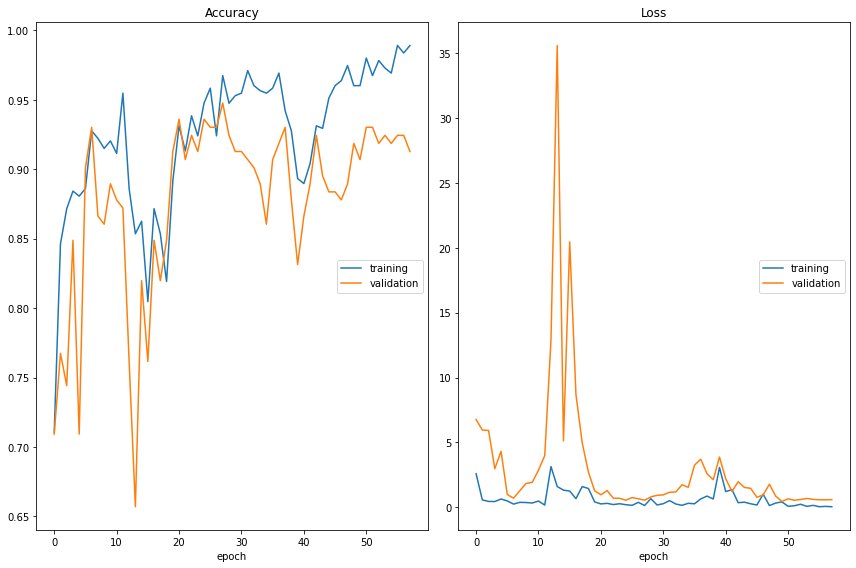

Accuracy
	training         	 (min:    0.711, max:    0.989, cur:    0.989)
	validation       	 (min:    0.657, max:    0.948, cur:    0.913)
Loss
	training         	 (min:    0.029, max:    3.127, cur:    0.031)
	validation       	 (min:    0.440, max:   35.617, cur:    0.576)
Epoch 00058: early stopping


In [ ]:
history_res50_2=res_2.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/5_breeds/fine_tuning2',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun2
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
res_2=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/5_breeds/fine_tuning2')

In [ ]:
res_2.evaluate(aug_test)

7/7 [==============================] - 1s 53ms/step - loss: 0.7196 - acc: 0.9291


[0.7195834517478943, 0.9291338324546814]

### Comparing models

In [ ]:
def plot_heatmap(true_labels,pred_labels, class_names, ax, title):
    g=sns.heatmap(
        confusion_matrix(true_labels, pred_labels), 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap='coolwarm',
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

    return g



In [ ]:
scratch_cnn=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/rotation_data_5_breeds')

In [ ]:
aug_test.reset()

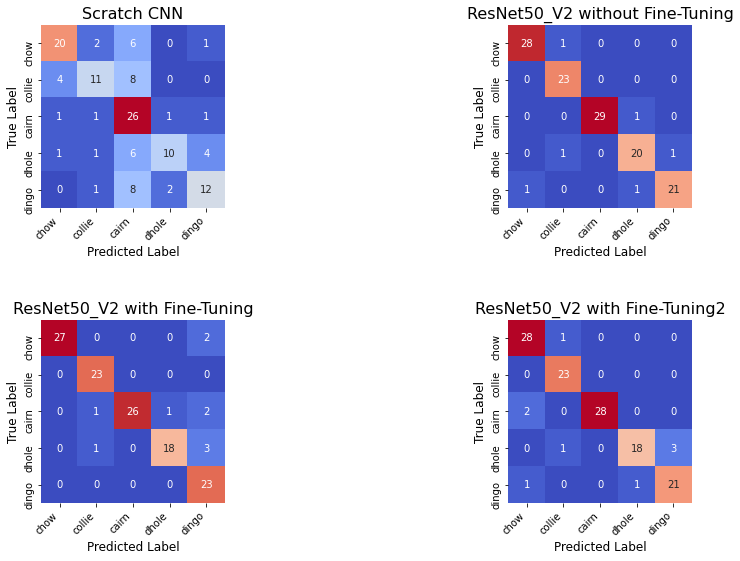

In [ ]:
classes=aug_test.class_indices.keys()
fig, axes = plt.subplots(
                     ncols=2,
                     nrows=2,
                     figsize=(15, 6))

ax1, ax2, ax3, ax4 = axes.flatten()

plot_heatmap(aug_test.classes, np.argmax(scratch_cnn.predict(aug_test), axis=1), classes, ax1, title="Scratch CNN")  
aug_test.reset()  
plot_heatmap(aug_test.classes, np.argmax(res_0.predict(aug_test), axis=1), classes, ax2, title="ResNet50_V2 without Fine-Tuning")  
aug_test.reset()  
plot_heatmap(aug_test.classes, np.argmax(res_1.predict(aug_test), axis=1), classes, ax3, title="ResNet50_V2 with Fine-Tuning")
aug_test.reset()
plot_heatmap(aug_test.classes, np.argmax(res_2.predict(aug_test), axis=1), classes, ax4, title="ResNet50_V2 with Fine-Tuning2")  
aug_test.reset()   

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

# 20 Breeds

In [ ]:
breeds=['basset', 'borzoi', 'Walker_hound', 'bluetick', 'beagle', 'black and tan_coonhound', 'English_foxhound', 'Irish_wolfhound', 'redbone', 'bloodhound', 'Italian_greyhound',
 'whippet', 'Scottish_deerhound', 'Weimaraner', 'Bedlington_terrier', 'American_Staffordshire_terrier', 'Saluki', 'Staffordshire_bullterrier', 'Norwegian_elkhound', 'Ibizan_hound',]

## Setting the data

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20)

Found 2314 images belonging to 20 classes.


In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 712 images belonging to 20 classes.


In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 534 images belonging to 20 classes.


## No fine tuning

In [ ]:
res_0_20breeds=create_model(n_classes=20,tuning_layers=0)

In [ ]:
plot_tun0_20=PlotLossesCallback()

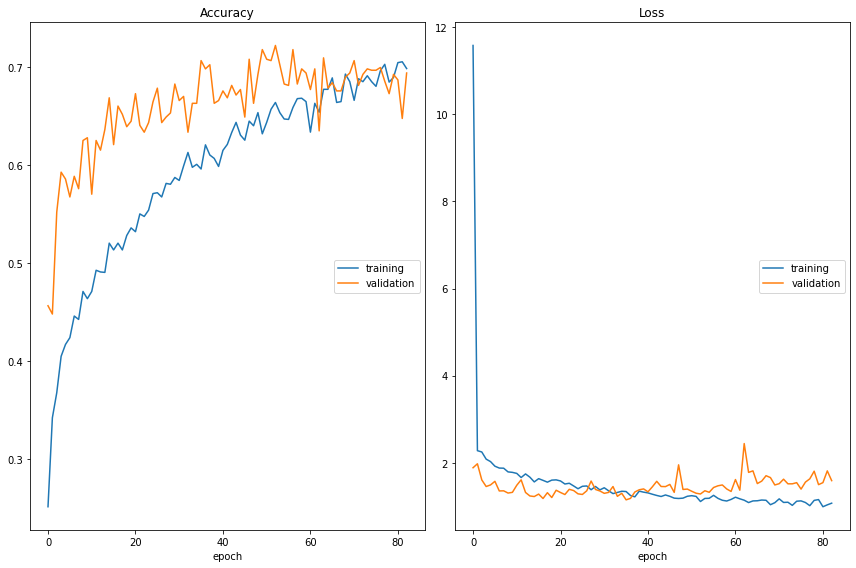

Accuracy
	training         	 (min:    0.252, max:    0.705, cur:    0.698)
	validation       	 (min:    0.448, max:    0.722, cur:    0.694)
Loss
	training         	 (min:    0.990, max:   11.580, cur:    1.071)
	validation       	 (min:    1.148, max:    2.440, cur:    1.589)
Epoch 00083: early stopping


In [ ]:
history_res50_20breeds=res_0_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/20_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0_20
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
res_0_20breeds.evaluate(aug_test)

27/27 [==============================] - 165s 6s/step - loss: 1.2855 - acc: 0.6985


[1.2854984998703003, 0.6985018849372864]

## Fine tuning

In [ ]:
res_1_20breeds=create_model(n_classes=20,tuning_layers=4)

In [ ]:
plot_tun1_20=PlotLossesCallback()

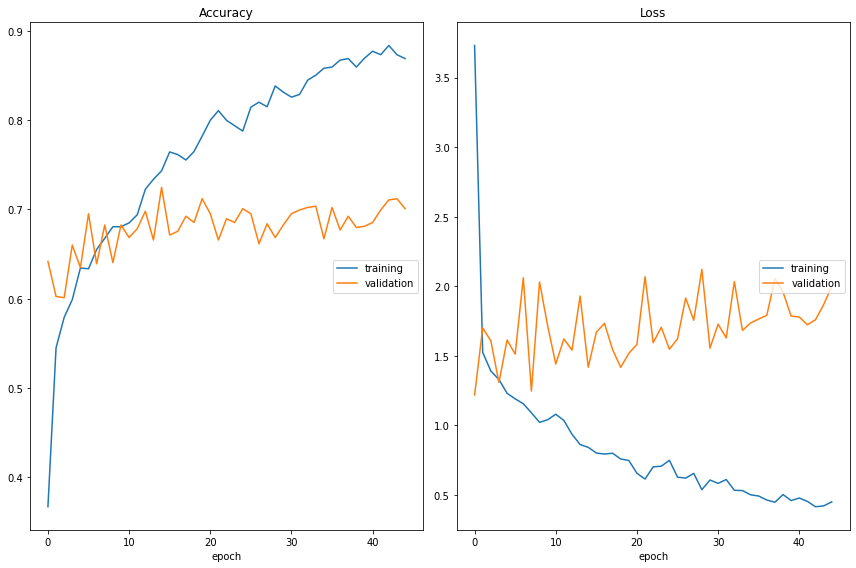

Accuracy
	training         	 (min:    0.367, max:    0.884, cur:    0.869)
	validation       	 (min:    0.601, max:    0.725, cur:    0.701)
Loss
	training         	 (min:    0.415, max:    3.731, cur:    0.450)
	validation       	 (min:    1.219, max:    2.121, cur:    1.999)
Epoch 00045: early stopping


In [ ]:
history_res1_20breeds=res_1_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/20_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1_20
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
res_1_20breeds.evaluate(aug_test)

27/27 [==============================] - 2s 55ms/step - loss: 1.5237 - acc: 0.6798


[1.5236537456512451, 0.6797752976417542]

## Fine tuning: 2 convolutional layers

In [ ]:
res_2_20breeds=create_model(n_classes=20,tuning_layers=11)

In [ ]:
plot_tun2_20=PlotLossesCallback()

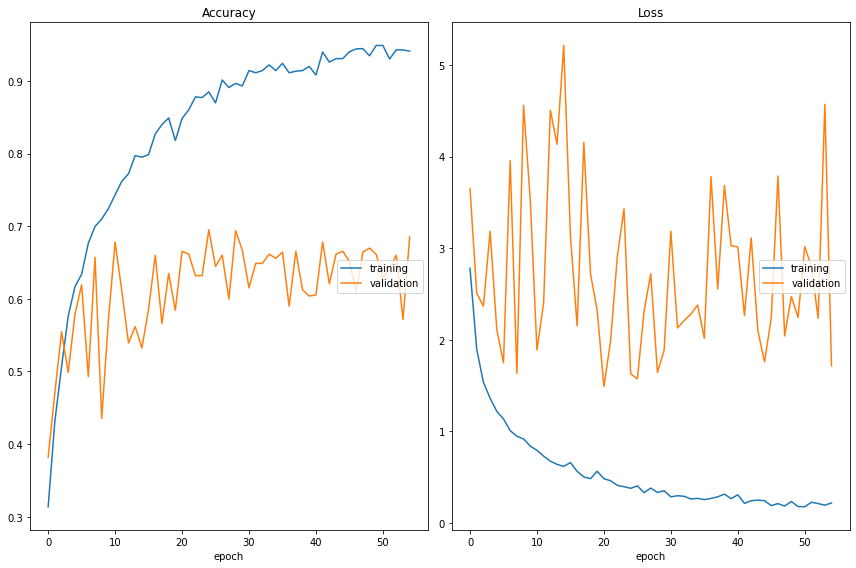

Accuracy
	training         	 (min:    0.314, max:    0.949, cur:    0.941)
	validation       	 (min:    0.382, max:    0.695, cur:    0.685)
Loss
	training         	 (min:    0.177, max:    2.780, cur:    0.219)
	validation       	 (min:    1.490, max:    5.212, cur:    1.715)
Epoch 00055: early stopping


In [ ]:
history_res2_20breeds=res_2_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/20_breeds/fine_tuning2',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun2_20
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
res_2_20breeds.evaluate(aug_test)

27/27 [==============================] - 2s 58ms/step - loss: 1.5983 - acc: 0.6742


[1.5982621908187866, 0.6741573214530945]

# 120 Breeds

## Setting the data

In [7]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20)

Found 13297 images belonging to 119 classes.


In [8]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 4055 images belonging to 119 classes.


In [9]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 3037 images belonging to 119 classes.


## No Fine tuning

In [ ]:
res_0_120breeds=create_model(n_classes=119,tuning_layers=0)

In [ ]:
plot_tun0_120=PlotLossesCallback()

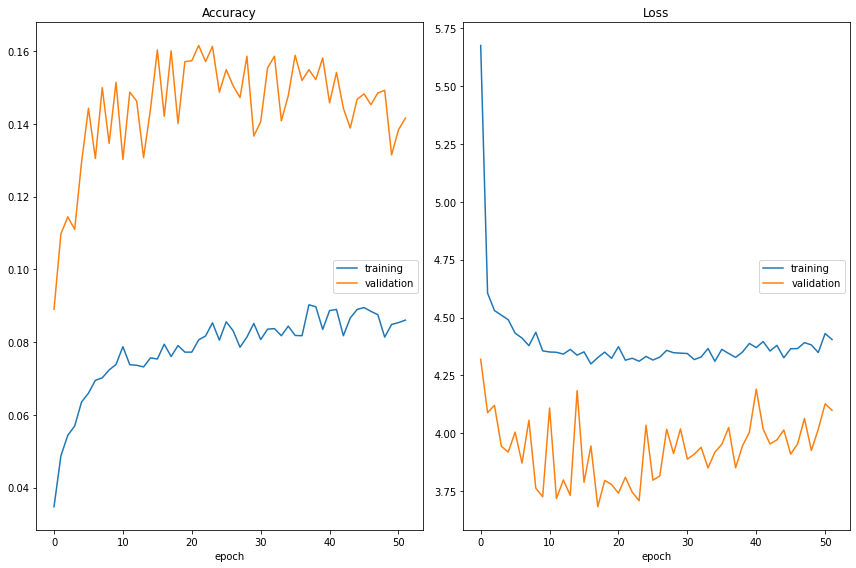

Accuracy
	training         	 (min:    0.035, max:    0.090, cur:    0.086)
	validation       	 (min:    0.089, max:    0.162, cur:    0.142)
Loss
	training         	 (min:    4.299, max:    5.675, cur:    4.405)
	validation       	 (min:    3.683, max:    4.319, cur:    4.099)
Epoch 00052: early stopping


In [ ]:
history_tun0_120breeds=res_0_120breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/120_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0_120
              ]
    )

In [ ]:
aug_test.reset()

In [ ]:
res_0_120breeds.evaluate(aug_test)

152/152 [==============================] - 685s 5s/step - loss: 3.9957 - acc: 0.1594


[3.99570369720459, 0.15936779975891113]

## fine tuning

In [ ]:
res_1_120breeds=create_model(n_classes=119,tuning_layers=4)

In [ ]:
plot_tun1_120=PlotLossesCallback()

In [ ]:
rotation_train.reset()

In [ ]:
aug_validation.reset()

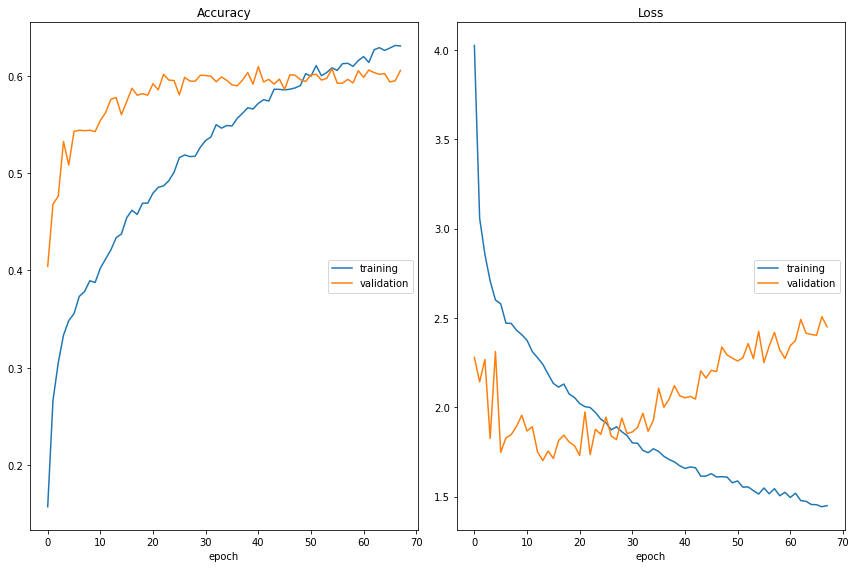

Accuracy
	training         	 (min:    0.157, max:    0.631, cur:    0.631)
	validation       	 (min:    0.404, max:    0.609, cur:    0.605)
Loss
	training         	 (min:    1.443, max:    4.026, cur:    1.449)
	validation       	 (min:    1.701, max:    2.507, cur:    2.450)
Epoch 69/1000
216/665 [========>.....................] - ETA: 1:39 - loss: 1.3801 - acc: 0.6587

In [ ]:
history_tun1_120breeds=res_1_120breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/120_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0_120
              ]
    )

In [10]:
res_1_120breeds=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/120_breeds/fine_tuning')

In [ ]:
aug_test.reset()

In [11]:
res_1_120breeds.evaluate(aug_test)

152/152 [==============================] - 683s 4s/step - loss: 2.1288 - acc: 0.6177


[2.1287670135498047, 0.6177148222923279]

## fine tuning: 2 convolutional layers

In [12]:
res_2_120breeds=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/ResNet50_V2/120_breeds/fine_tuning2')

In [13]:
aug_test.reset()

In [14]:
res_2_120breeds.evaluate(aug_test)

152/152 [==============================] - 13s 76ms/step - loss: 2.5509 - acc: 0.6062


[2.5508601665496826, 0.6061903238296509]